In [10]:
import pandas as pd
import numpy as np

# Load the Excel sheet
df = pd.read_excel("D:\intership\week2\yahoo_data.xlsx", sheet_name=0)

# Step 1: Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Step 3: Convert numeric columns to appropriate datatypes
numeric_cols = ['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 4: Fill missing values (forward fill)
df.fillna(method='ffill', inplace=True)

# Step 5: Rename columns for ease
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj_Close'}, inplace=True)


<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Anas\AppData\Local\Temp\ipykernel_15404\2848425446.py:5: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_excel("D:\intership\week2\yahoo_data.xlsx", sheet_name=0)
C:\Users\Anas\AppData\Local\Temp\ipykernel_15404\2848425446.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [11]:
# Step 6: Add Financial Indicators

# Simple Moving Average (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Exponential Moving Average (EMA)
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Std'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])


In [12]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Load dataset
df = pd.read_excel("yahoo_data.xlsx")

# Fix column names and convert types
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj_Close'}, inplace=True)

# Convert columns to numeric
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df.fillna(method='ffill', inplace=True)

# === Add Financial Indicators === #
# Simple Moving Average (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Exponential Moving Average (EMA)
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Std'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])

# Drop NaNs introduced by rolling calculations
df.dropna(inplace=True)

# === Anomaly Detection === #
features = ['Close', 'SMA_10', 'EMA_10', 'RSI_14', 'BB_Upper', 'BB_Lower']
X = df[features]

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 = Anomaly

# View sample anomalies
anomalies = df[df['anomaly'] == 1]
print(anomalies[['Date', 'Close', 'anomaly']].head())


C:\Users\Anas\AppData\Local\Temp\ipykernel_15404\1457574130.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


          Date     Close  anomaly
163 2018-12-21  22445.37        1
164 2018-12-24  21792.20        1
170 2019-01-03  22686.22        1
460 2020-02-28  25409.36        1
469 2020-03-12  21200.62        1


23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing


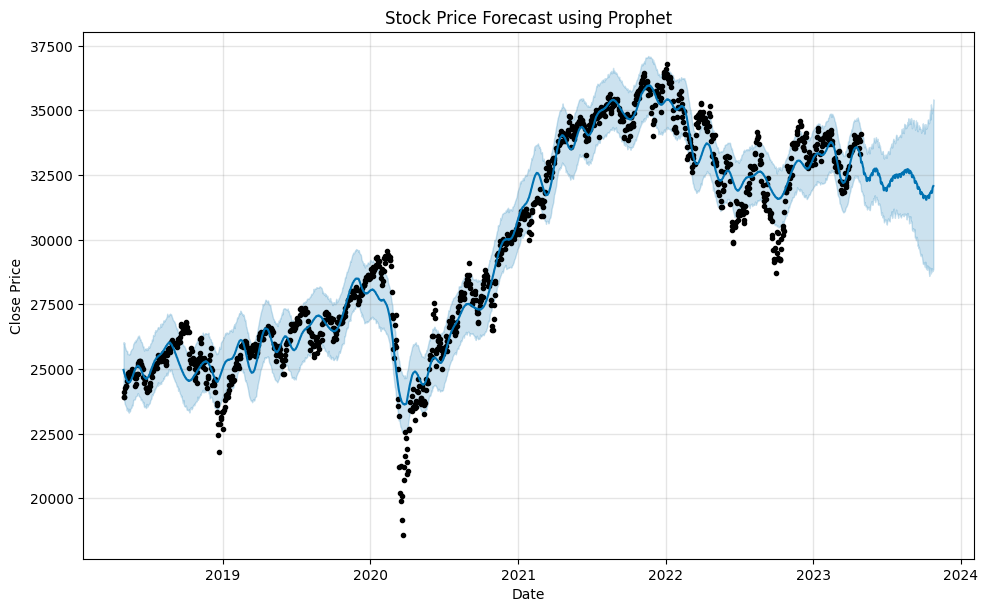

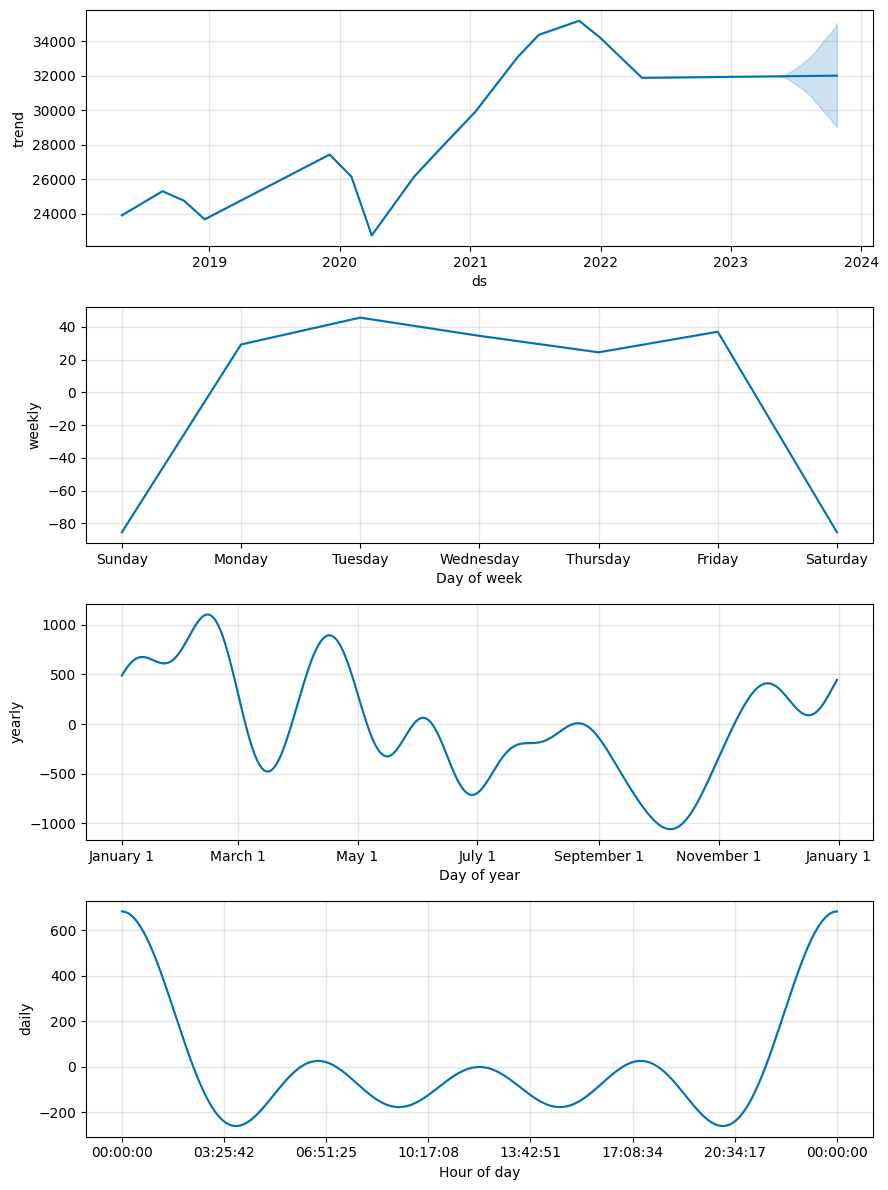

In [13]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare dataset
df = pd.read_excel("yahoo_data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Close*': 'Close'}, inplace=True)
df = df[['Date', 'Close']].dropna()
df = df.sort_values('Date')

# Rename columns for Prophet
df_prophet = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Create future dataframe (e.g., next 180 days)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Stock Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Optional: plot trend and seasonality components
model.plot_components(forecast)
plt.show()
